In [61]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
class FeatureSet(Dataset):
    def __init__(self,X):
        self.len = len(X)
        self.X = cat([zeros(4,5000),X,zeros(4,5000)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx:idx+9].flatten()

In [62]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_0/best_model.pt',map_location='cpu'))
model.to(DEVICE)

Gandalf(
  (encoder): Frodo(
    (block1): ResidualBlock(
      (c1): Conv1d(1, 8, kernel_size=(8,), stride=(1,), padding=same, bias=False)
      (bn1): LayerNorm((8, 5000), eps=1e-05, elementwise_affine=False)
      (c2): Conv1d(8, 8, kernel_size=(5,), stride=(1,), padding=same, bias=False)
      (bn2): LayerNorm((8, 5000), eps=1e-05, elementwise_affine=False)
      (c3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same, bias=False)
      (bn3): LayerNorm((8, 5000), eps=1e-05, elementwise_affine=False)
      (c4): Conv1d(1, 8, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (bn4): LayerNorm((8, 5000), eps=1e-05, elementwise_affine=False)
    )
    (block2): ResidualBlock(
      (c1): Conv1d(8, 16, kernel_size=(8,), stride=(1,), padding=same, bias=False)
      (bn1): LayerNorm((16, 5000), eps=1e-05, elementwise_affine=False)
      (c2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=same, bias=False)
      (bn2): LayerNorm((16, 5000), eps=1e-05, elementwis

In [63]:
from mne.io import read_raw_edf
mapping = {
    "SPARC-10-M":"EEG 1", 
    "SPARC-11-M":"EEG 1",
    "SPARC-12-M":"EEG 1",
    "SPARC-13-M":"EEG 1",
    "SPARC-14-M":"EEG 1",
    "SPARC-15-M":"EEG 1",
    "SPARC-17-M":"EEG 2",
    "SPARC-18-M":"EEG 1",
    "SPARC-2-F":"EEG 1",
    "SPARC-4-F":"EEG 1",
    "SPARC-5-F":"Channel-2",
    "SPARC-8-F":"Channel-10",
    "SPARC-9-F ":"Channel-2",
    "SPARC-10-F":"Channel-50",
    "SPARC-11-F":"Channel-18",
    "SPARC-12-F":"Channel-42",
    "SPARC-13-F":"EEG 1",
    "SPARC-14-F":"EEG 1",
    "SPARC-15-F":"EEG 1",
    "SPARC-16-F":"EEG 2"
}
filename = list(mapping.keys())[1]
raw = read_raw_edf(f'../ICV/{filename}.edf',include=[mapping[filename]],verbose=False)
print(f'mapping: {mapping[filename]}')
for name in raw.ch_names:
    print(name)
eeg = raw.get_data(picks=mapping[filename])
eeg = eeg.reshape(-1,5000)
print(eeg.shape)
eeg = torch.from_numpy(eeg).float()
dataloader = DataLoader(dataset=FeatureSet(eeg),batch_size=32,shuffle=False)
def score(dataloader,model,DEVICE=DEVICE):
    with torch.no_grad():
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        for Xi in tqdm(dataloader):
            Xi = Xi.to(DEVICE)
            logits = model(Xi)
            y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu()])

    return y_pred,y_logits

mapping: EEG 1
EEG 1
(76411, 5000)


In [65]:
y_pred,y_logits = score(dataloader,model,'cuda')

100%|██████████| 2388/2388 [01:34<00:00, 25.28it/s]


In [66]:
len(y_pred)

76411

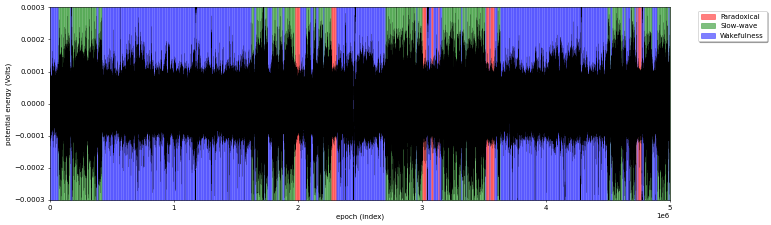

In [75]:
fig, ax = plt.subplots(figsize=(16,5),dpi=50)
import matplotlib.patches as patches

start_epoch = 20000
length = 1000
plt.plot(eeg[start_epoch:start_epoch+length].flatten(),'black',linewidth=.2);

colors = ['red','green','blue']
epochs = []
for i in range(length):
    stage = int(y_pred[start_epoch+i])
    ax.fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

# 4. Add a legend for the background colors using proxy artists
red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
plt.ylim([-.0003,.0003])
plt.margins(0,0)
# ax.legend(handles=[red_patch, green_patch,blue_patch],loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
          fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
plt.ylabel('potential energy (Volts)')
# plt.xticks(epochs,range(length));
plt.savefig('out.jpg')

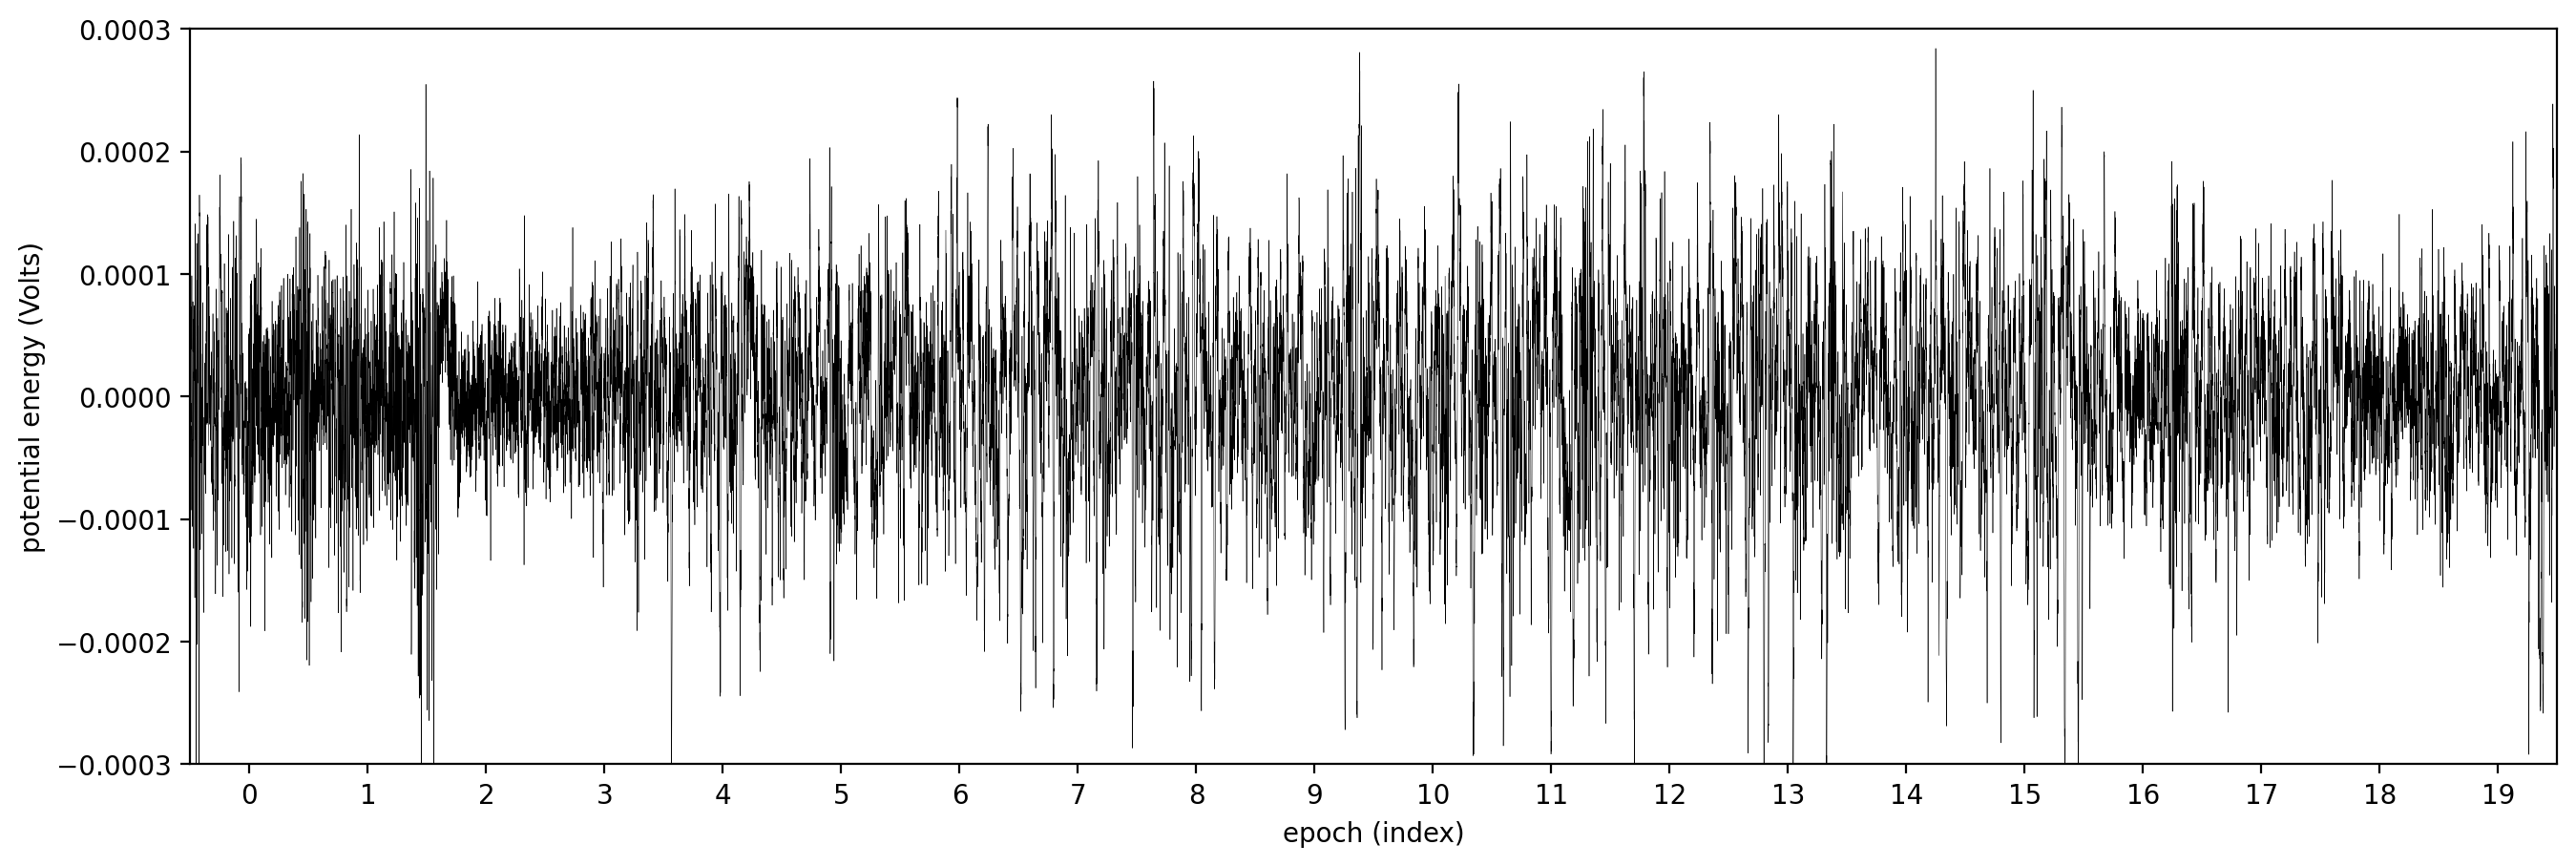

In [30]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,5),dpi=200)

start_epoch = 10000
length = 20
plt.plot(eeg[start_epoch:start_epoch+length].flatten(),'black',linewidth=.2)

epochs = []
for i in range(length):
    # plt.axvline(i*5000,color='black',linestyle='--',linewidth=1)
    epochs.append(i*5000+2500)
    
plt.xlabel('epoch (index)')
plt.ylabel('potential energy (Volts)')
plt.xticks(epochs,range(length));
plt.ylim([-.0003,.0003])
plt.margins(0,0)